In [1]:
import time
import numpy as np
import yaml
import torch
torch.cuda.is_available()
from tqdm import tqdm
from utils.parse import parse_args, load_model, get_clusters, get_pca, get_tsne,get_hier_clusters, get_medoid_indices
from dataset.dataloader import data_loader
import itertools
import matplotlib.pyplot as plt
import gc  
import os 
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = yaml.load(open("config/config_rep_objs.yaml"),Loader=yaml.FullLoader)
config

{'dataset': {'path': '/mnt/data/das-sb/dataset_hdf5_processed',
  'type': 'abc',
  'num_point': 2048,
  'train_val_percent': 0.85,
  'train_test_split': 0.95},
 'model': {'path': '/home/das-sb/GIT/source_library/log/PointNet/2024-02-22_12-03/sinkhorn/PointNet/checkpoints/self_best_model.pth',
  'name': 'BYOL',
  'proj_dim': 256,
  'tau': 0.01,
  'K': 64,
  'angle': 0.0,
  'md': 'pn',
  'crop': [1.0, 1.0],
  'dims': 1024,
  'neighs': 20},
 'util': {'gpu': 0, 'workers': 8},
 'training': {'train': True,
  'unsup': True,
  'l_type': 'gl',
  'is_recon': True,
  'normal': False,
  'log_dir': 'PointNet',
  'batch_size': 64,
  'epoch': 200,
  'learning_rate': 0.001,
  'lr_decay': 0.5,
  'lr_patience': 5,
  'optimizer': 'AdamW',
  'decay_rate': 0.0001,
  'aug': 'jitter',
  'early_stopping': True,
  'early_stopping_patience': 10,
  'cb': False,
  'return_embedding': True},
 'pca': {'n_components': 512},
 'pca_2': {'n_components': 154},
 'tsne': {'n_components': 2},
 'results': {'dir_path': '/mnt

In [3]:
train_data_loader, val_data_loader = data_loader(config)

Successfully load Abc with 807200 instances
Successfully load Abc with 142447 instances


In [4]:
with torch.cuda.device(config['util']['gpu']):
    ema_net = load_model(config)
    emb_all_points = []
    all_points = []
    start = time.time()
    for batch_id, train_data in tqdm(enumerate(train_data_loader, 0), total=len(train_data_loader), smoothing=0.9,desc = 'train dataset'):
            x1, _ = train_data
            x1 = x1.cuda()
            x1 = x1.transpose(2, 1)
            emb =  ema_net(x1,return_embedding=config['training']['return_embedding'])
            emb_all_points.append(emb[0].detach().cpu().numpy())
            all_points.append(train_data[0].detach().cpu().numpy())
    del train_data_loader
    gc.collect()
    torch.cuda.empty_cache() 
    for batch_id, val_data in tqdm(enumerate(val_data_loader, 0), total=len(val_data_loader), smoothing=0.9,desc = 'val dataset'):
        x1, _ = val_data
        x1 = x1.cuda()
        x1 = x1.transpose(2, 1)
        emb =  ema_net(x1,return_embedding=config['training']['return_embedding'])
        emb_all_points.append(emb[0].detach().cpu().numpy())
        all_points.append(val_data[0].detach().cpu().numpy())
    del val_data_loader
    gc.collect()
    torch.cuda.empty_cache() 
del ema_net
gc.collect()
torch.cuda.empty_cache() 
all_points = np.concatenate(all_points,axis=0)
end = time.time()
np.random.seed(42)
    

val dataset: 100%|██████████| 2226/2226 [00:55<00:00, 39.84it/s]


In [5]:
emb_all_points = np.concatenate(emb_all_points,axis=0)
print(f'Dimension of dataset embedding {emb_all_points.shape}')

Dimension of dataset embedding (949647, 1024)


In [6]:
num_points = 1000
red_all_points = np.take(all_points, np.random.choice(np.array(list(range(0,all_points.shape[0]))), num_points, replace=False), axis=0, out=None, mode='raise')
    
print(f'Dimension of dataset {red_all_points.shape} and it takes {end-start} seconds or {(end-start)/60} minutes or {(end-start)/3600} hours')

red_emb_all_points = np.take(emb_all_points, np.random.choice(np.array(list(range(0,emb_all_points.shape[0]))), num_points, replace=False), axis=0, out=None, mode='raise')

print(f'Dimension of embedding of dataset {red_emb_all_points.shape} and it takes {end-start} seconds or {(end-start)/60} minutes or {(end-start)/3600} hours')

Dimension of dataset (1000, 2048, 3) and it takes 396.1404941082001 seconds or 6.602341568470001 minutes or 0.11003902614116669 hours
Dimension of embedding of dataset (1000, 1024) and it takes 396.1404941082001 seconds or 6.602341568470001 minutes or 0.11003902614116669 hours


In [7]:
red_dim_emb_all_points = get_pca(n_components=config['pca']['n_components'],data=red_emb_all_points)

# red_emb_all_points = get_pca(n_components=config['pca_2']['n_components'], data=red_emb_all_points)

red_dim_emb_all_points = get_tsne(n_components=config['tsne']['n_components'], data=red_dim_emb_all_points)

red_dim_emb_rel_points = red_dim_emb_all_points.copy()

Dimesnion after PCA (1000, 512) and it takes 1.4611239433288574 seconds or 0.024352065722147622 minutes or 0.0004058677620357937 hours
Dimesnion after TSNE (1000, 2) and it takes 3.323868989944458 seconds or 0.0553978164990743 minutes or 0.0009232969416512383 hours


In [8]:
clf, pred, num_clusters = get_clusters(data = red_dim_emb_rel_points,store_centers = 'medoid', classifier=config['results']['classifier'],min_samples=config['results']['min_samples']) 
original_clusters = pred.copy()
cluster_members = []
clusters = np.unique(original_clusters).tolist()
for cluster in clusters:
    idx = (original_clusters == cluster).nonzero()[0]
    cluster_points = np.take(red_dim_emb_all_points,idx,axis=0)
    cluster_members.append(cluster_points)

count=0

hdbscan Clustering
The value of min_cluster_size is 2
Number of outliers 116
Number of clusters excluding outliers 308
Clustering validation dataset took 0.1136312484741211 seconds


In [9]:
while True:
    red_dim_emb_rel_points, original_clusters, clusters, cluster_members, num_clusters, clf = get_hier_clusters(clf = clf, all_points=red_dim_emb_all_points,rel_points=red_dim_emb_rel_points,  original_clusters=original_clusters, clusters = clusters, cluster_members=cluster_members, min_samples=config['results']['min_samples'], classifier=config['results']['classifier'],count=count)

    with open(os.path.join(config['results']['dir_path'],f"all_medoids_{config['results']['classifier']}_tsne.npy"), 'wb') as f:
        np.save(f, clf.medoids_)
    all_medoids = np.load(os.path.join(config['results']['dir_path'],f"all_medoids_{config['results']['classifier']}_tsne.npy"))

    all_medoid_indices = get_medoid_indices(medoids=all_medoids,data=red_dim_emb_all_points)
    all_rep_emb = np.take(red_dim_emb_all_points,all_medoid_indices,axis=0)
    print(f'Dimension of embedding of all representative  objects {all_rep_emb.shape}')

    all_red_rep_emb = np.take(red_dim_emb_all_points,all_medoid_indices,axis=0)
    print(f'Dimension of reduced embedding embedding of all representative  objects {all_red_rep_emb.shape}')

    with open(os.path.join(config['results']['dir_path'],f"all_rep_emb_{config['results']['classifier']}_tsne.npy"), 'wb') as f:
        np.save(f, all_rep_emb)

    all_rep_objects = np.take(red_all_points,all_medoid_indices,axis=0)
    print(f'Dimension of all representative  objects {all_rep_objects.shape}')

    with open(os.path.join(config['results']['dir_path'],f"all_rep_objects_{config['results']['classifier']}_tsne.npy"), 'wb') as f:
        np.save(f, all_rep_objects)
        
    total_num_clusters = len(np.unique(original_clusters).tolist())
    print(f'The total number of clusters including outliers after level {count} are {total_num_clusters}')

    if total_num_clusters<=config['results']['n_clusters']:
        break
    else:
        emb_all_points = all_rep_emb
        red_emb_all_points = all_red_rep_emb
        all_points = all_rep_objects
        count+=1

        

(308, 2)


100%|██████████| 308/308 [00:00<00:00, 18345.13it/s]


Dimension of embedding of all representative  objects (308, 2)


100%|██████████| 308/308 [00:00<00:00, 22867.76it/s]

Dimension of embedding of all representative  objects (308, 2)
Dimension of reduced embedding embedding of all representative  objects (308, 2)
Dimension of all representative  objects (308, 2048, 3)
The total number of clusters including outliers after level 0 are 309
 Number of points to be clustered are 308
hdbscan Clustering


The value of min_cluster_size is 2
Number of outliers 39
Number of clusters excluding outliers 87
Clustering validation dataset took 0.05069708824157715 seconds
(87, 2)
Now number of clusters are 127
The number are outliers in level 1 are 116


100%|██████████| 87/87 [00:00<00:00, 27084.13it/s]


Dimension of embedding of all representative  objects (87, 2)
Dimension of embedding of all representative  objects including outliers (126, 2)


100%|██████████| 87/87 [00:00<00:00, 20356.16it/s]

Dimension of embedding of all representative  objects (87, 2)
Dimension of reduced embedding embedding of all representative  objects (87, 2)
Dimension of all representative  objects (87, 2048, 3)
The total number of clusters including outliers after level 1 are 127


In [10]:
np.unique(original_clusters)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125])

In [11]:
red_dim_emb_rel_points.shape

(126, 2)

In [12]:
cluster_medoid_indices = get_medoid_indices(medoids=red_dim_emb_rel_points, data=red_dim_emb_all_points)
len(cluster_medoid_indices)

100%|██████████| 126/126 [00:00<00:00, 11954.18it/s]


126

In [13]:
corres_point_cloud = np.take(red_all_points,cluster_medoid_indices,axis=0)
corres_point_cloud.shape

(126, 2048, 3)

In [14]:
cluster_members = []
for cluster_idx, medoid in enumerate(red_dim_emb_rel_points):
    idx = (original_clusters == cluster_idx).nonzero()[0]
    cluster_points = np.take(red_all_points,idx,axis=0)
    cluster_members.append(cluster_points)

In [31]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)
for idx, (medoid, members) in enumerate(zip(corres_point_cloud,cluster_members)):
    # ax.scatter(medoid[:,0],medoid[:,1],medoid[:,2])
    os.makedirs(f'images/clusters/cluster_{idx}',exist_ok=True)
    os.makedirs(f'images/medoids',exist_ok=True)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(medoid)
    o3d.io.write_point_cloud(f"images/medoids/medoid_{idx}.ply", pcd)
    # pcd_load = o3d.io.read_point_cloud(f"images/medoids/medoid_{idx}.ply")
    # o3d.visualization.draw_geometries([pcd_load]) # can't find display
    for m_idx, member in enumerate(members):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(member)
        o3d.io.write_point_cloud(f"images/clusters/cluster_{idx}/{m_idx}.ply", pcd)
        # pcd_load = o3d.io.read_point_cloud(f"images/cluster_{idx}/{m_idx}.ply")
        # o3d.visualization.draw_geometries([pcd_load]) # can't find display
        # break
    
    # print(members.shape)
    # break
# plt.show()

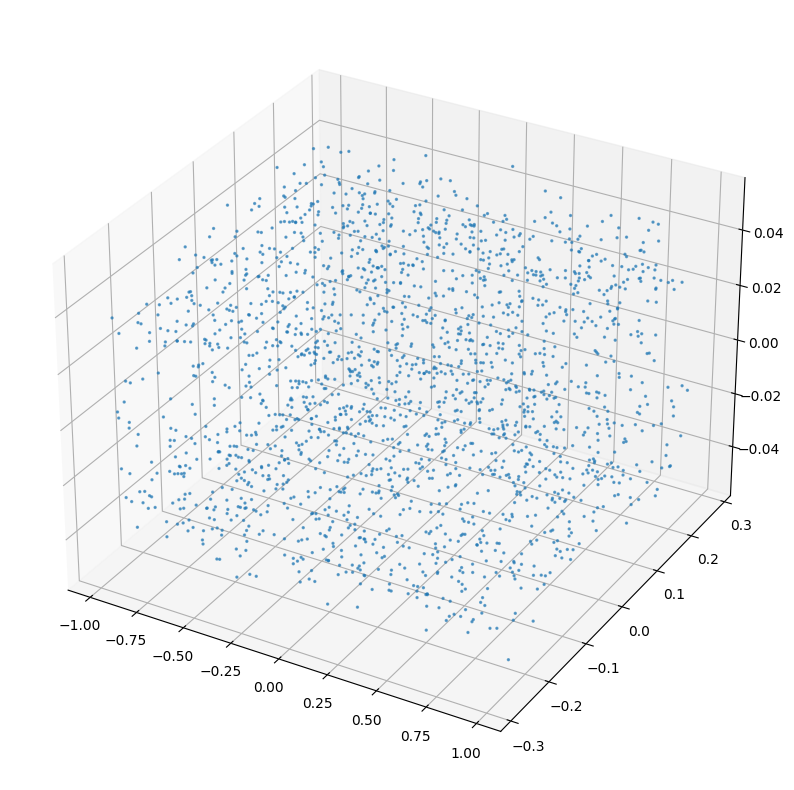

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for idx, (medoid, members) in enumerate(zip(corres_point_cloud,cluster_members)):
    ax.scatter(medoid[:,0],medoid[:,1],medoid[:,2],s=2.0,alpha=0.6)
    break
plt.show()